In [3]:
import time
import warnings
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

Using TensorFlow backend.


In [4]:
# Better graphs, less noise
plt.rcParams['figure.figsize'] = (20.0, 10.0)
warnings.filterwarnings("ignore")

In [5]:
# Several functions to load, normalize and plot time series data
def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'r').read()
    data = f.split('\n')
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    if normalise_window:
        result = normalise_windows(result)
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  
    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    # Normalize the data to be consumed by the model
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in xrange(len(data)/prediction_len):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in xrange(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in xrange(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    plt.autoscale
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Forecast')
    plt.legend()
    plt.title('LSTM Server Request Forecast')
    plt.show()
    
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in xrange(i * prediction_len)]
        plt.plot(padding + data, label='Forecast')
        plt.legend()
    plt.title('LSTM Multiple Forecasts')
    plt.show()

In [7]:
#Step 1 Load Data 
x_train, y_train, x_test, y_test = load_data(
    'data/nginx_requests.bal-demoA.deltas.csv', 50, True)

In [5]:
#Step 2 Build Model
#Recurrent Neural Network with sequencial model
model = Sequential()

# Set an LSTM to the model with input dimension to 1 with 50 output units
model.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

# Use the linear dense layer to aggregate the data from this prediction vector
# into one single value
model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
# Compile the model using mean squared error 
# and use gradient as our optimizer called rmsprop
model.compile(loss='mse', optimizer='rmsprop')
print 'compilation time : ', time.time() - start

compilation time :  0.0127050876617


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 50)          10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________


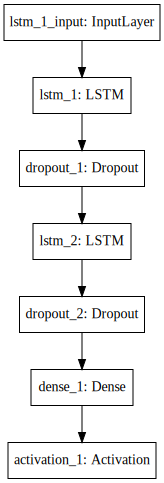

In [18]:
model.summary()
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [7]:
# Do a Tensorboard callback
from keras.callbacks import TensorBoard
tbCallBack = TensorBoard(log_dir='lstm_logs', histogram_freq=0, write_graph=True, write_images=True)

#Step 3 Train the model
model.fit(
    x_train,
    y_train,
    batch_size=512,
    nb_epoch=10,
    validation_split=0.04,
    callbacks=[tbCallBack])

Train on 1416 samples, validate on 59 samples
Epoch 1/100
1416/1416 [==============================] - 4s - loss: 0.0797 - val_loss: 0.0621
Epoch 2/100
1416/1416 [==============================] - 3s - loss: 0.0494 - val_loss: 0.0614
Epoch 3/100
1416/1416 [==============================] - 4s - loss: 0.0427 - val_loss: 0.0604
Epoch 4/100
1416/1416 [==============================] - 3s - loss: 0.0407 - val_loss: 0.0569
Epoch 5/100
1416/1416 [==============================] - 3s - loss: 0.0417 - val_loss: 0.0572
Epoch 6/100
1416/1416 [==============================] - 3s - loss: 0.0400 - val_loss: 0.0523
Epoch 7/100
1416/1416 [==============================] - 3s - loss: 0.0439 - val_loss: 0.0518
Epoch 8/100
1416/1416 [==============================] - 4s - loss: 0.0380 - val_loss: 0.0498
Epoch 9/100
1416/1416 [==============================] - 4s - loss: 0.0370 - val_loss: 0.0509
Epoch 10/100
1416/1416 [==============================] - 4s - loss: 0.0365 - val_loss: 0.0468
Epoch 11/100


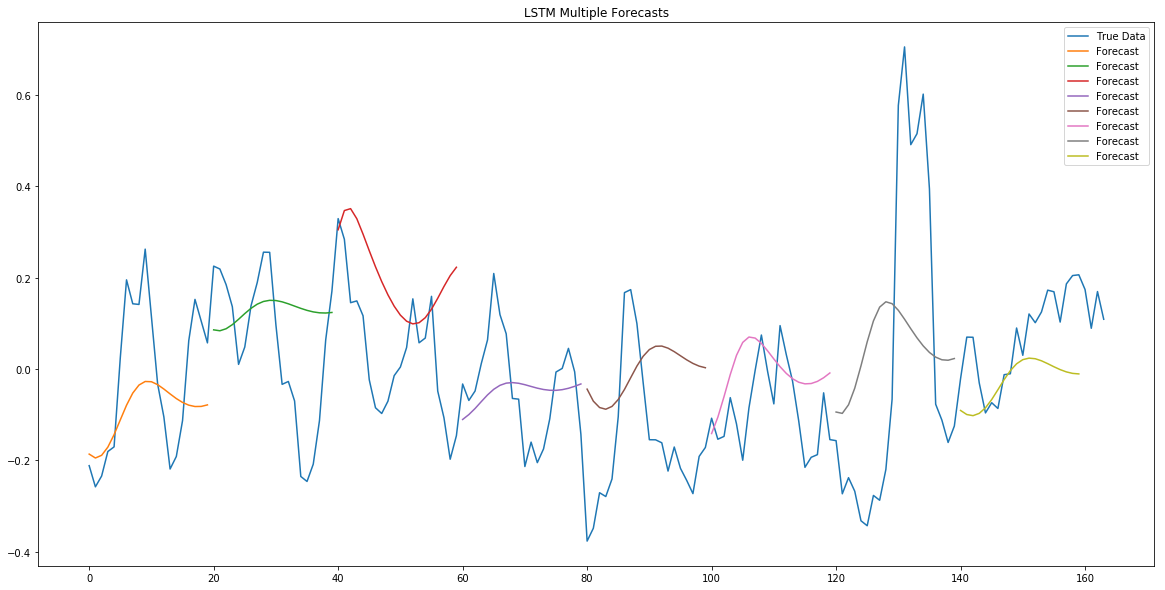

In [21]:
#Step 4 - Plot the predictions!
# plot multiple predictions
predictionsM = predict_sequences_multiple(model, x_test, 50, 20)
plot_results_multiple(predictionsM, y_test, 20)

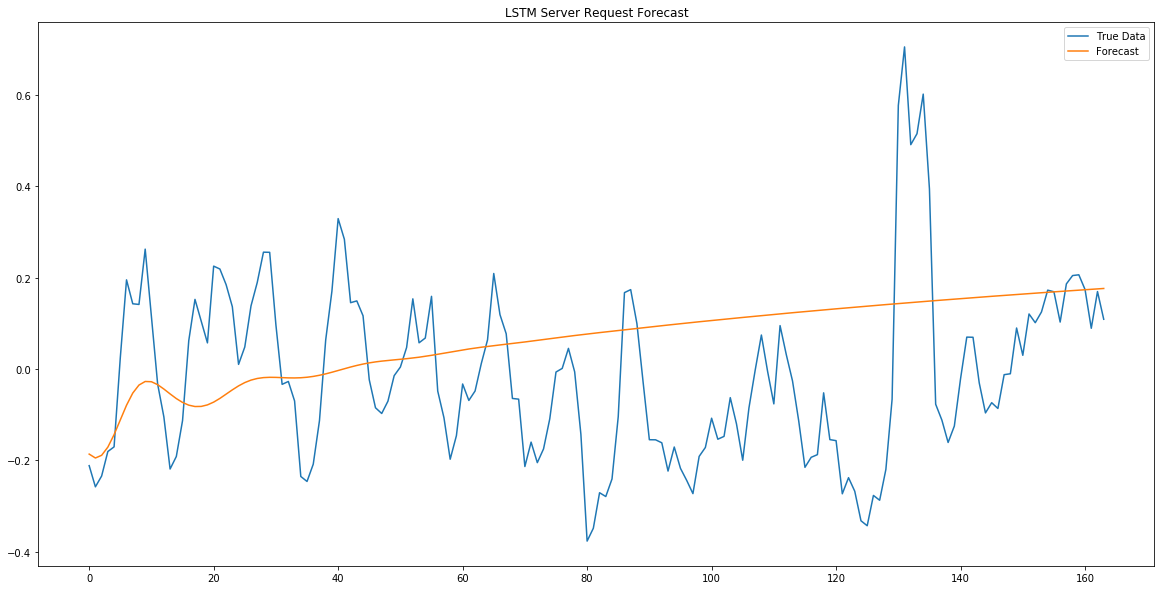

In [22]:
# plot long term prediction
predictionsF = predict_sequence_full(model, x_test, 50)
plot_results(predictionsF, y_test)

In [10]:
# https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model
# Used to save the model and the weights for post usage
from keras.models import load_model
timestr = time.strftime("%Y%m%d-%H%M%S")
model.save('nginx_requests_model'+timestr+'.h5')
model.save_weights('nginx_requests_weights'+timestr+'.h5')
# del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
# model = load_model('my_model.h5')
# model.load_weights('my_model_weights.h5')

http://www.jakob-aungiers.com/articles/a/LSTM-Neural-Network-for-Time-Series-Prediction

In [ ]:
# Show tensorboard

!tensorboard --logdir=lstm_logs 